In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
from opt import generate_exclusion_list
from theano import tensor as T
sns.set_context('paper', font_scale=1.5)

/anaconda2/envs/compgen/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
proc_data = pd.read_pickle('data/exp2_data.pkl')

# exclude! ...
excluded = generate_exclusion_list(
    proc_data, training_contexts=7, goal_chance=1/4.)
for e in excluded:
    proc_data = proc_data[proc_data.subj != e]
uids = list(set(proc_data.subj))
print len(uids)

100%|██████████| 148/148 [01:12<00:00,  1.33it/s]


114


# Analyses

In [3]:
proc_data['Accuracy'] = proc_data['Reward'] / 10.0
proc_data['Training'] = proc_data.loc[:, 'Context'] < 8

Below, we plot the training data as a check that subjects learned the task

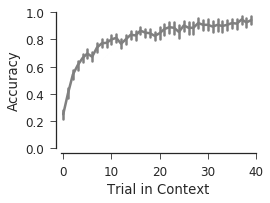

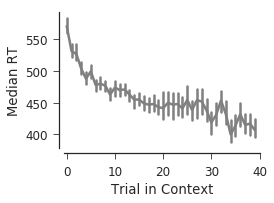

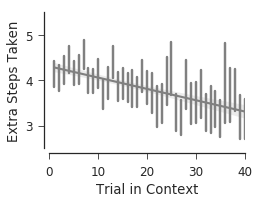

In [4]:
import scipy.stats
color = 'grey'
figsize = (3.5, 2.5)

with sns.axes_style('ticks'):
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='Accuracy', 
                  data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                  ax=ax, markers=' ', color=color)
    lb, ub = ax.get_xlim()
    lb, ub = int(lb), int(ub)
    step = 10
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([0, 1])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.pointplot(x='Times Seen Context', y='rt', data=proc_data[proc_data['Training']], 
                  estimator=np.median, ax=ax,  markers=' ', color=color)
    ax.set_ylabel('Median RT')
    ax.set_xlabel('Trial in Context')
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    sns.despine(offset=5)
    
    plt.figure(figsize=figsize)
    ax = plt.gca()
    sns.regplot(x='Times Seen Context', y='Normalized Steps Taken',
                x_estimator=np.mean,
                data=proc_data[proc_data['Training'] & proc_data['In Goal']],
                truncate=True,
                ax=ax, marker= ' ', color=color)
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylim([2.5, 5.5])
    ax.set_xlim([lb, ub+1])
    ax.set_xticks(range(lb, ub+2, step))
    ax.set_xticklabels(range(lb, ub+2, step))
    ax.set_ylabel('Extra Steps Taken')
    ax.set_xlabel('Trial in Context')
    sns.despine(offset=5)

In [5]:
# create meaningful regressors
# really on only want to look at training
X0 = proc_data[proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii
n_subj = int(max(X0.sub_id) + 1)

y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm_train_acc:
    
    a = pm.Normal('alpha', mu=0., sd=100)
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(a + b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_train_acc = pm.sample(2000)
    
pm.stats.summary(trace_train_acc, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda2/envs/compgen/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, alpha]
100%|██████████| 2500/2500 [05:17<00:00,  7.88it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.114509,0.003453,0.000068,0.107435,0.120935,2262.0,0.999894
beta_reps,0.770471,0.045599,0.000893,0.685137,0.860486,2084.0,0.999804


In [6]:
y = np.array(1. / X0['rt'].values)
y = (y - y.mean()) / y.std()

with pm.Model() as glm_rt:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=100.)
    b_cr = pm.Normal('beta_reps', mu=0., sd=100.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat =  b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    # inference
    trace_rt = pm.sample(2000)
    
pm.stats.summary(trace_rt, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [02:43<00:00, 15.30it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,0.015766,0.000662,0.000011,0.014423,0.016995,3480.0,1.000002
beta_reps,0.082745,0.015380,0.000277,0.052464,0.112028,4000.0,0.999793


In [9]:
y = np.array(X0['Normalized Steps Taken'].values)

with pm.Model() as glm_steps:
    
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times', mu=0., sd=10.)  # have to use a more restrictive prior for the Poisson regression
    b_cr = pm.Normal('beta_reps',  mu=0., sd=10.)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0.,   sd=5.)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=5.)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)

    # define linear model and exp link function
    theta = b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx]
            
    ## Define Poisson likelihood
    y_hat = pm.Poisson('y', mu=np.exp(theta), observed=y)
    
    # inference
    trace_steps = pm.sample(2000)
    
pm.stats.summary(trace_steps, varnames=['beta_times', 'beta_reps'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [02:35<00:00, 16.10it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_times,-0.005934,0.000360,0.000009,-0.006669,-0.005256,1754.0,1.000062
beta_reps,-0.373035,0.009118,0.000135,-0.390993,-0.355492,3642.0,1.000076


Here, we plot the differences scores for the test conditions across time. Thes are the a priori comparisons identified by the generative models

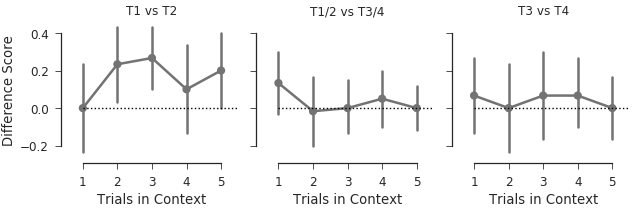

In [10]:
# plot the difference scores across time
df0 = df = proc_data[~proc_data['Training'] & proc_data['In Goal'] & 
                     (proc_data['Times Seen Context'] < 6)].copy()

score = list()

for uid in uids:
    subj_df = df0.loc[df0.subj == uid, :]

    if subj_df['Trial Number'].max() == df0['Trial Number'].max():

        grouped = subj_df.groupby(['Context', 'Times Seen Context']).mean()

        diff_1 = grouped.loc[8, 'Accuracy'] - grouped.loc[9, 'Accuracy']
        diff_2 = (grouped.loc[8, 'Accuracy'] + grouped.loc[9, 'Accuracy']) * 0.5 -\
                   (grouped.loc[10, 'Accuracy'] + grouped.loc[11, 'Accuracy']) * 0.5
        diff_3 = grouped.loc[10, 'Accuracy'] -  grouped.loc[11, 'Accuracy']

        n = len(diff_1)

        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T1/2 vs T3/4'] * n,
                    'Difference Score': diff_2,
                    'uniqueid': [uid] * n,
            }))
        
        score.append(pd.DataFrame({
                    'Trials in Context': range(1, n+1),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'uniqueid': [uid] * n,
            }))

score = pd.concat(score)      
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1 vs T2'],  
                  ax=axes[0], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T1/2 vs T3/4'], 
                  ax=axes[1], color=[0.45, 0.45, 0.45])
    sns.pointplot(x='Trials in Context', y='Difference Score',  err_style='ci_bars',
                  ci=95, data=score[score.Comparison=='T3 vs T4'],  
                  ax=axes[2], color=[0.45, 0.45, 0.45])
    

    axes[0].set_xticklabels(range(1, 7))
    axes[0].set_ylabel('Difference Score')
    axes[1].set_ylabel('')
    axes[2].set_ylabel('')
    
    axes[0].set_title('T1 vs T2', fontdict={'size': 12})
    axes[1].set_title('T1/2 vs T3/4', fontdict={'size': 12})
    axes[2].set_title('T3 vs T4', fontdict={'size': 12})
    
    for ax in axes:
        ax.plot([0, 6], [0, 0], 'k:')
    
    plt.subplots_adjust(wspace=0.3)
    sns.despine(offset=5, trim=True)
    plt.tight_layout()


In [11]:
# run the bayesian GLM

X0 = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()

X0['subj_id'] = [None] * len(X0)
for ii, uid in enumerate(uids):
    X0.loc[X0.subj == uid, 'sub_id'] = ii

n_subj = int(max(X0.sub_id) + 1)


y = np.array(X0['Accuracy'].values)
subj_idx = np.array(X0['sub_id'].values, dtype='int')
x_1 = np.array(X0.Context.values == 8, dtype=int) - \
     (X0.Context.values == 9 )
    
x_2 = np.array((X0.Context.values == 8) | (X0.Context.values == 9), dtype=int) - \
     ((X0.Context.values == 10) | (X0.Context.values == 11))
    
x_3 = np.array(X0.Context.values == 10, dtype=int) - \
     (X0.Context.values == 11)
    
x_ti = X0['Times Seen Context'].values
x_cr = X0['Context Repeated'].values

def tinvlogit(x):
    return T.exp(x) / (1 + T.exp(x))

with pm.Model() as glm:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_1 = pm.Normal('beta_ctxT1vs2',   mu=0., sd=100)
    b_2 = pm.Normal('beta_ctxT12vs34', mu=0., sd=100)
    b_3 = pm.Normal('beta_ctxT3vs4',   mu=0., sd=100)
    b_ti = pm.Normal('beta_times',     mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',      mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_1 * x_1 + b_2 * x_2 + b_3 * x_3 + \
                      b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times, beta_ctxT3vs4, beta_ctxT12vs34, beta_ctxT1vs2]
100%|██████████| 2500/2500 [01:15<00:00, 33.05it/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
summary = pm.stats.summary(trace, varnames=[
    'beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4', 'beta_times', 'beta_reps'
])
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_ctxT1vs2,0.140877,0.063616,0.000814,0.015537,0.263800,4000.0,0.999765
beta_ctxT12vs34,0.059545,0.046482,0.000620,-0.030448,0.150054,4000.0,1.000253
beta_ctxT3vs4,0.046734,0.064023,0.000731,-0.075890,0.178475,4000.0,0.999831
beta_times,0.481948,0.034843,0.001022,0.413920,0.550666,869.0,1.001985
beta_reps,0.922280,0.126566,0.002147,0.670080,1.159677,4000.0,1.000101


In [13]:
# one sided tests
print 'P(1 > 2)     = %g' % np.mean(trace['beta_ctxT1vs2'] > 0)
print 'P(1+2 > 3+4) = %g' % np.mean(trace['beta_ctxT12vs34'] > 0)
print 'P(3 > 4)     = %g' % np.mean(trace['beta_ctxT3vs4'] > 0)

P(1 > 2)     = 0.9865
P(1+2 > 3+4) = 0.8975
P(3 > 4)     = 0.7815


In [14]:
# Compare model to a reduced model with out the contrasts
with pm.Model() as glm_reduced:
        
    # Intercept for each subjects, distributed around group mean mu_a
    b_ti = pm.Normal('beta_times',    mu=0., sd=100)
    b_cr = pm.Normal('beta_reps',     mu=0., sd=100)
    
    # random effects modeled as constant addded/subtracted per subject
    mu_sub = pm.Normal('mu_subj', mu=0., sd=100)
    sigma_sub = pm.HalfCauchy('sigma_sub', beta=100)
    a_sub = pm.Normal('a_subj', mu=mu_sub, sd=sigma_sub, shape=n_subj)
    
    # Regression model
    y_hat = tinvlogit(b_ti * x_ti + b_cr * x_cr + a_sub[subj_idx])
        
    #error term
    stdev = pm.HalfCauchy('eps', beta=100)
    
    # Data likelihood
    y_like = pm.Normal('like', mu=y_hat, sd=stdev, observed=y)
    
    trace_reduced = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps_log__, a_subj, sigma_sub_log__, mu_subj, beta_reps, beta_times]
100%|██████████| 2500/2500 [00:43<00:00, 57.80it/s]
The number of effective samples is smaller than 25% for some parameters.


In [15]:
df_comp_LOO = pm.compare((trace, trace_reduced),
                          (glm, glm_reduced), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Full', 'Reduced'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Full,3156.37,124.23,0,0.52,60.82,0,1
Reduced,3156.65,119.71,0.29,0.48,60.6,6.13,1


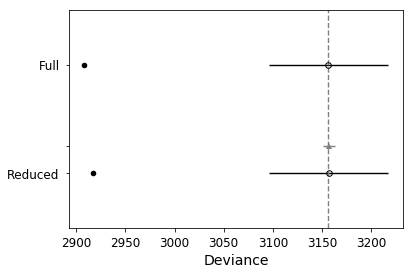

In [16]:
pm.compareplot(df_comp_LOO)

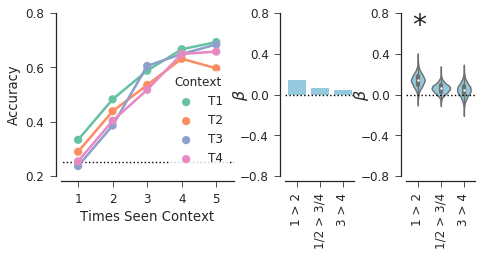

In [17]:
betas = pd.DataFrame({
        'T1vsT2': trace['beta_ctxT1vs2'],
        'T1/2vsT3/4': trace['beta_ctxT12vs34'],
        'T3vsT4':   trace['beta_ctxT3vs4']
    })
from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(7.43, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2.5, 1, 1], wspace=0.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2]))
    
    # show time series data as well
    df = proc_data[~proc_data['Training'] & proc_data['In Goal']].copy()
    
    ax=axes[0]
    sns.pointplot(x='Times Seen Context', y='Accuracy', hue='Context', #units='uniqueid',
                  estimator=np.mean, marker='.',
                        data=df[df['Times Seen Context'] < 6], palette='Set2', ax=ax, ci=None)

    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')

    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    ax.set_xticklabels(range(1, 11))
    ax.set_ylabel('Accuracy')
    ax.plot([-1, 6], [1./4, 1./4], 'k:')
    ax.set_ylim([0.2, 0.8])
    sns.despine(offset=5)

    ax = axes[1]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=axes[1],
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[2]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-10, fontdict={'size': 16, 'weight': 'bold'})
    
    for ii in range(1, 3):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.8, -.4, 0, 0.4, 0.8])
        axes[ii].set_xlabel('')

    # only the first comparison is significant
    ax.annotate("*", xy=(-0.25, 0.6), size=28)

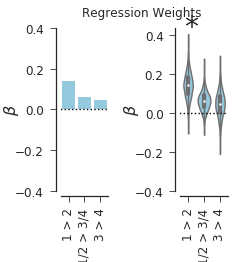

In [18]:

from matplotlib import gridspec

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(3, 3))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=1.5)
    axes = (plt.subplot(gs[0]), plt.subplot(gs[1]))    

    ax = axes[0]
    sns.barplot(data=pd.melt(betas), x='variable', y='value', ax=ax,
                 estimator=np.median, color='skyblue', ci=None,
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})

    ax = axes[1]
    sns.violinplot(data=pd.melt(betas), x='variable', y='value', ax=ax, linestyles='None',
                 estimator=np.median, color='skyblue', 
                   order=['T1vsT2', 'T1/2vsT3/4', 'T3vsT4'])
    ax.set_yticks([-0.8, -.4, 0, 0.4, 0.8])
    ax.set_ylabel(r'$\beta$', labelpad=-6, fontdict={'size': 16, 'weight': 'bold'})
    
    sns.despine(offset=5)
    
    for ii in range(0, 2):
        plt.sca(axes[ii])
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        axes[ii].plot([-1, 3], [0, 0], 'k:')
        axes[ii].set_yticks([-0.4, -.2, 0, 0.2, 0.4])
        axes[ii].set_xlabel('')

    for ii, label in enumerate(['beta_ctxT1vs2', 'beta_ctxT12vs34', 'beta_ctxT3vs4']):
        if np.sign(summary.loc[label, 'hpd_2.5']) ==  np.sign(summary.loc[label, 'hpd_97.5']):
            ax.annotate("*", xy=(ii-0.22, 0.4), size=28)
            
    plt.suptitle('Regression Weights')
            
    plt.savefig('exp2_fig1_data.png', dpi=300, bbox_inches='tight')

# First Trial analysis


In [19]:
# Do a "Bayesian Analysis" to follow up analyses on the accuracy in the first context
# Generate the data
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1)
               & ~proc_data['Training'] ]

y_t1 = d0.loc[d0.Context == 8, 'Accuracy'].values 
y_t2 = d0.loc[d0.Context == 9, 'Accuracy'].values 
y_t3 = d0.loc[d0.Context == 10, 'Accuracy'].values 
y_t4 = d0.loc[d0.Context == 11, 'Accuracy'].values 


with pm.Model() as binom_model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    # define the likelihood
    y_t1 = pm.Bernoulli('y_t1', p=theta1, observed=y_t1)
    y_t2 = pm.Bernoulli('y_t2', p=theta2, observed=y_t2)
    y_t3 = pm.Bernoulli('y_t3', p=theta3, observed=y_t3)
    y_t4 = pm.Bernoulli('y_t4', p=theta4, observed=y_t4)
    
    # Generate a MCMC chain
    trace_bin = pm.sample(10000, pm.Metropolis())  # Use Metropolis sampling

pm.stats.summary(trace_bin)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [theta4_logodds__]
>Metropolis: [theta3_logodds__]
>Metropolis: [theta2_logodds__]
>Metropolis: [theta1_logodds__]
100%|██████████| 10500/10500 [00:47<00:00, 219.83it/s]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.332885,0.044238,0.000396,0.247780,0.419252,12295.0,1.000063
theta2,0.290024,0.042583,0.000413,0.210743,0.377664,13108.0,0.999957
theta3,0.236569,0.040224,0.000357,0.162754,0.317069,12850.0,0.999987
theta4,0.254347,0.040666,0.000339,0.174870,0.333463,13736.0,0.999999


# Frequency with which each goal was chosen in novel contexts

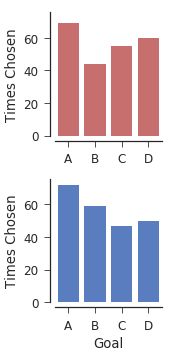

In [20]:
with sns.axes_style('ticks'):
    fig, axes = plt.subplots(2, 1, sharey=True, figsize=(2.5, 5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=axes[1], order='A B C D'.split(), color=cc[0])
    sns.countplot(d1['Chosen Goal'], ax=axes[0], order='A B C D'.split(), color=cc[2])
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')
    
    ax = axes[1]
    ax.set_xlabel('Goal')

    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()


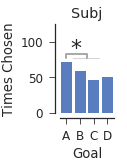

In [21]:
sns.set_context('paper', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==8) | (proc_data['Context']==9))]

    cc = sns.color_palette('muted')
    sns.countplot(d0['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[0])

    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 75
    y_min = 0
    ax.text(2./3., 90, "*", size=22,
        horizontalalignment='center', verticalalignment='center')

    ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(1.5, y_max), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.arrow(1.47, y_max+1, 0,  0.02, 
             width=0.2, head_width=2, head_length=0.1,  color='#aaaaaa')

    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])
    ax.set_title(r'Subj')


    plt.tight_layout()
    plt.savefig('exp2_qual1.png', dpi=300, bbox_inches='tight')

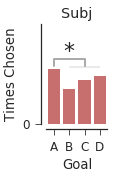

In [22]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))
    d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
           & (proc_data['Times Seen Context']==1) & 
                   ((proc_data['Context']==11) | (proc_data['Context']==10)) ]

    cc = sns.color_palette('muted')
    sns.countplot(d1['Chosen Goal'], ax=ax, order='A B C D'.split(), color=cc[2])

    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    
    # b/c the statistics below are signficant, plot the error bars
    # Add significance bars -- I've done this by hand
    y_max = 100
    y_min = 0
    ax.text(1.0, 90, "*", size=22,
        horizontalalignment='center', verticalalignment='center')

    ax.annotate("", xy=(0, 70), xycoords='data', xytext=(2, 70), textcoords='data', 
                arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                           connectionstyle="bar,fraction=0.3"))
    ax.arrow(2.0, 71, 0,  0.01, width=0.1, head_width=2,
             head_length=0.0,  color='#aaaaaa')
    ax.set_ylim([0, 125])
    ax.set_yticks(range(0, 50, 100))
    ax.set_title(r'Subj')

    plt.savefig('exp2_qual2.png', dpi=300, bbox_inches='tight')

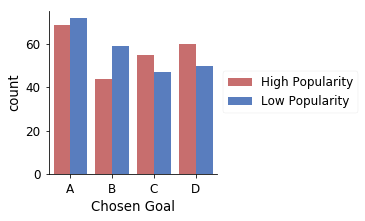

In [23]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[2], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
sns.despine()

Use Bayesian Model Comparisions to look at whether the hand influenced the goal choice probability. 

In [24]:
# d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
#            & (proc_data['Times Seen Context']==1) & ((proc_data['Context']>=8))]

# # Generate the data
# y_A = np.array(d0['Chosen Goal'].values == 'A') 
# y_B = np.array(d0['Chosen Goal'].values == 'B') 
# y_C = np.array(d0['Chosen Goal'].values == 'C') 
# y_D = np.array(d0['Chosen Goal'].values == 'D') 

d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 8) | (proc_data['Context'] == 9))
      ]
d1 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) & 
       ((proc_data['Context'] == 10) | (proc_data['Context'] == 11))
      ]

y_A_m0 = np.array(d0['Chosen Goal'].values == 'A') 
y_B_m0 = np.array(d0['Chosen Goal'].values == 'B') 
y_C_m0 = np.array(d0['Chosen Goal'].values == 'C') 
y_D_m0 = np.array(d0['Chosen Goal'].values == 'D') 

y_A_m1 = np.array(d1['Chosen Goal'].values == 'A') 
y_B_m1 = np.array(d1['Chosen Goal'].values == 'B') 
y_C_m1 = np.array(d1['Chosen Goal'].values == 'C') 
y_D_m1 = np.array(d1['Chosen Goal'].values == 'D') 


with pm.Model() as model:
    # define the prior
    theta1 = pm.Beta('theta1', 10e-5, 10e-5)  # prior
    theta2 = pm.Beta('theta2', 10e-5, 10e-5)  # prior
    theta3 = pm.Beta('theta3', 10e-5, 10e-5)  # prior
    theta4 = pm.Beta('theta4', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta1, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta2, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta3, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta4, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta2, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta3, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta4, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace = pm.sample(2000) 


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta4_logodds__, theta3_logodds__, theta2_logodds__, theta1_logodds__]
100%|██████████| 2500/2500 [00:05<00:00, 485.33it/s]


In [25]:
with pm.Model() as model_null:
    # define the prior
    theta = pm.Beta('theta1', 10e-5, 10e-5)  # prior

    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=theta, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=theta, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=theta, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=theta, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=theta, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=theta, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=theta, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=theta, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_null = pm.sample(2000)  # Use Metropolis sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta1_logodds__]
100%|██████████| 2500/2500 [00:02<00:00, 1116.88it/s]


In [26]:


with pm.Model() as model_goal_full:
    # define the prior
    thetaA0 = pm.Beta('thetaA0', 10e-5, 10e-5)  # prior
    thetaB0 = pm.Beta('thetaB0', 10e-5, 10e-5)  # prior
    thetaC0 = pm.Beta('thetaC0', 10e-5, 10e-5)  # prior
    thetaD0 = pm.Beta('thetaD0', 10e-5, 10e-5)  # prior
    
    thetaA1 = pm.Beta('thetaA1', 10e-5, 10e-5)  # prior
    thetaB1 = pm.Beta('thetaB1', 10e-5, 10e-5)  # prior
    thetaC1 = pm.Beta('thetaC1', 10e-5, 10e-5)  # prior
    thetaD1 = pm.Beta('thetaD1', 10e-5, 10e-5)  # prior
    
    # define the likelihood
    y_A_m0_hat = pm.Bernoulli('y_A0', p=thetaA0, observed=y_A_m0)
    y_B_m0_hat = pm.Bernoulli('y_B0', p=thetaB0, observed=y_B_m0)
    y_C_m0_hat = pm.Bernoulli('y_C0', p=thetaC0, observed=y_C_m0)
    y_D_m0_hat = pm.Bernoulli('y_D0', p=thetaD0, observed=y_D_m0)
    
    y_A_m1_hat = pm.Bernoulli('y_A1', p=thetaA1, observed=y_A_m1)
    y_B_m1_hat = pm.Bernoulli('y_B1', p=thetaB1, observed=y_B_m1)
    y_C_m1_hat = pm.Bernoulli('y_C1', p=thetaC1, observed=y_C_m1)
    y_D_m1_hat = pm.Bernoulli('y_D1', p=thetaD1, observed=y_D_m1)
    
    # Generate a MCMC chain
    trace_full = pm.sample(2000)  # Use Metropolis sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [thetaD1_logodds__, thetaC1_logodds__, thetaB1_logodds__, thetaA1_logodds__, thetaD0_logodds__, thetaC0_logodds__, thetaB0_logodds__, thetaA0_logodds__]
100%|██████████| 2500/2500 [00:10<00:00, 244.03it/s]


In [27]:
df_comp_LOO = pm.compare((trace, trace_null, trace_full),
                          (model, model_null, model_goal_full), ic='LOO')
df_comp_LOO.index =  [
    {ii: name for ii, name in enumerate(['Independent', 'Flat', 'Joint'])}[idx] 
    for idx in df_comp_LOO.index ]

df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,warning
Independent,2047.67,3.88,0,0.62,41.1,0,1
Joint,2051.36,8.19,3.69,0.12,41.41,4.49,1
Flat,2053.39,0.99,5.72,0.26,40.6,6.91,1


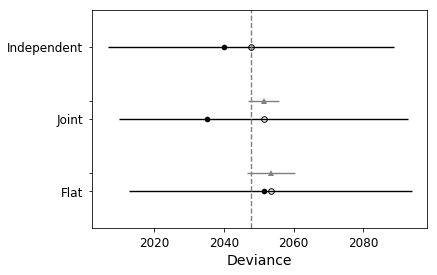

In [28]:
pm.compareplot(df_comp_LOO)

### comparisons of interest

0.999


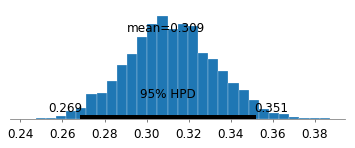

In [29]:
# P(A) > 0.25
print np.mean(trace['theta1']>0.25)
pm.plot_posterior(trace['theta1'])

0.99975


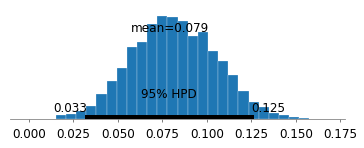

In [30]:
# P(A) > P(B, C or D)
print np.mean(trace['theta1'] > 1./3*(trace['theta2'] + trace['theta3'] + trace['theta4']))
pm.plot_posterior(trace['theta1'] - 1./3*(trace['theta2'] + trace['theta3'] + trace['theta4']))

1.0


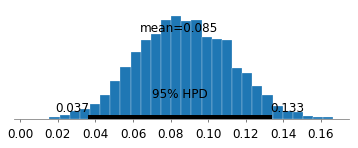

In [31]:
# P(A) > P(B or C)
print np.mean(trace['theta1'] > 1./2*(trace['theta2'] + trace['theta3']))
pm.plot_posterior(trace['theta1'] - 1./2*(trace['theta2'] + trace['theta3']))

In [32]:
pm.stats.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta1,0.309375,0.021053,0.000265,0.269473,0.350930,4000.0,0.999777
theta2,0.226109,0.018971,0.000228,0.191799,0.265050,4000.0,0.999812
theta3,0.223429,0.019246,0.000278,0.187103,0.261890,4000.0,0.999766
theta4,0.241552,0.020037,0.000250,0.204126,0.281784,4000.0,1.000588


In [33]:
pm.stats.summary(trace_full)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
thetaA0,0.316104,0.030973,0.000408,0.251988,0.372897,4000.0,1.000078
thetaB0,0.258776,0.029468,0.000371,0.200525,0.315501,4000.0,1.000144
thetaC0,0.206290,0.027006,0.000354,0.154081,0.258755,4000.0,0.999810
thetaD0,0.219619,0.027129,0.000379,0.166488,0.272684,4000.0,0.999828
thetaA1,0.302373,0.029939,0.000444,0.244869,0.360393,4000.0,0.999775
thetaB1,0.193378,0.026308,0.000405,0.143543,0.243924,4000.0,0.999786
thetaC1,0.241655,0.028435,0.000504,0.188217,0.297939,3350.0,1.000103
thetaD1,0.263563,0.030013,0.000489,0.207547,0.325950,4000.0,0.999765


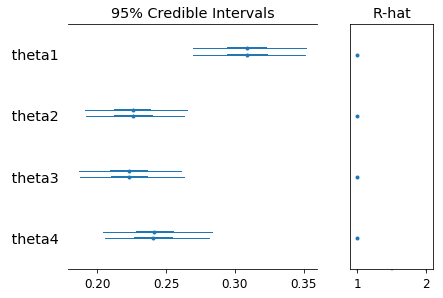

In [34]:
pm.forestplot(trace)

0.995


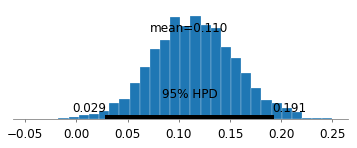

In [35]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA0'] > trace_full['thetaC0'])
pm.plot_posterior(trace_full['thetaA0'] - trace_full['thetaC0'])

0.9265


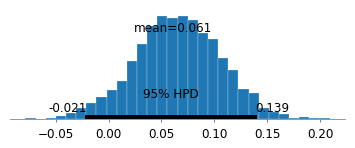

In [36]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaA1'] - trace_full['thetaC1'])

0.993


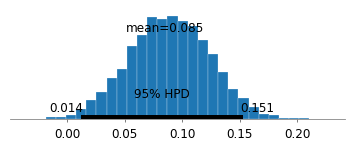

In [37]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > 
              0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))
pm.plot_posterior(trace_full['thetaA1'] - 
                  0.5*(trace_full['thetaC1'] + trace_full['thetaB1']))

0.37575


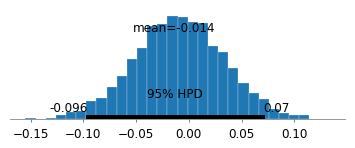

In [38]:
# full model
# P(A | map1) > P(C | map1)
print np.mean(trace_full['thetaA1'] > trace_full['thetaA0'])
pm.plot_posterior(trace_full['thetaA1'] - trace_full['thetaA0'])

0.35125


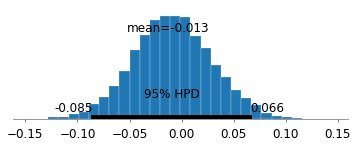

In [39]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaD0'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaD0'])

0.17675


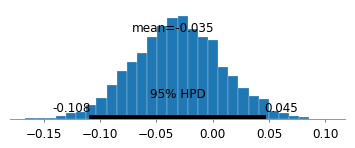

In [40]:
# full model
# P(C | map1) > P(D | map1)
print np.mean(trace_full['thetaC0'] > trace_full['thetaC1'])
pm.plot_posterior(trace_full['thetaC0'] - trace_full['thetaC1'])

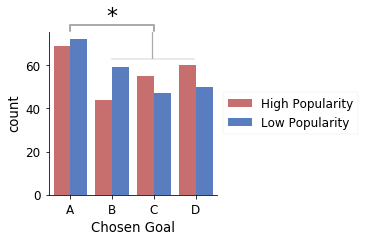

In [41]:
d0 = proc_data[proc_data['In Goal'] & (proc_data['Times Seen Context']==1) 
               & (proc_data['Training']==False) 
           & (proc_data['Times Seen Context']==1)].copy()
d0['Counts'] = [1] * len(d0)

d0['Mapping'] = ['High Popularity'] * len(d0)
d0.loc[(d0['Context'] == 8) | (d0['Context'] == 9), 'Mapping'] = 'Low Popularity'

fig, ax = plt.subplots(figsize=(3, 3))
cc = [sns.color_palette('muted')[2], sns.color_palette('muted')[0]]
sns.countplot(data=d0, x='Chosen Goal', order='A B C D'.split(), hue='Mapping', 
             palette=cc)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Add significance bars -- I've done this by hand
y_max = 75
y_min = 0

ax.text(1.0, y_max + abs(y_max - y_min)*0.1, "*", size=22,
   horizontalalignment='center', verticalalignment='center')

ax.annotate("", xy=(0, y_max), xycoords='data', xytext=(2, y_max), textcoords='data', 
            arrowprops=dict(arrowstyle="-", lw=2.0, ec='#aaaaaa',
                       connectionstyle="bar,fraction=0.1"))
ax.arrow(1.97, y_max+1, 0,  -13, width=0.03, head_width=2, head_length=0.0,  color='#aaaaaa')

sns.despine()